In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


(37229, 9)
Index(['Time', 'Class', 'Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C'], dtype='object')


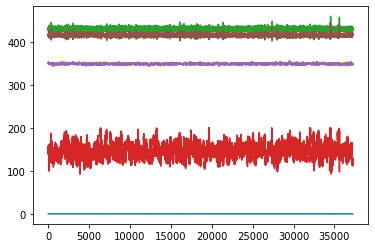

In [28]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
print(dfRaw.shape)
print(dfRaw.columns)


d=dfRaw.iloc[:,2:8]

plt.plot(d)
plt.show()

In [29]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fraud_data)/len(data)), 4),"%")


data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0001 %


[0.51899794 0.22757746 0.20203542]


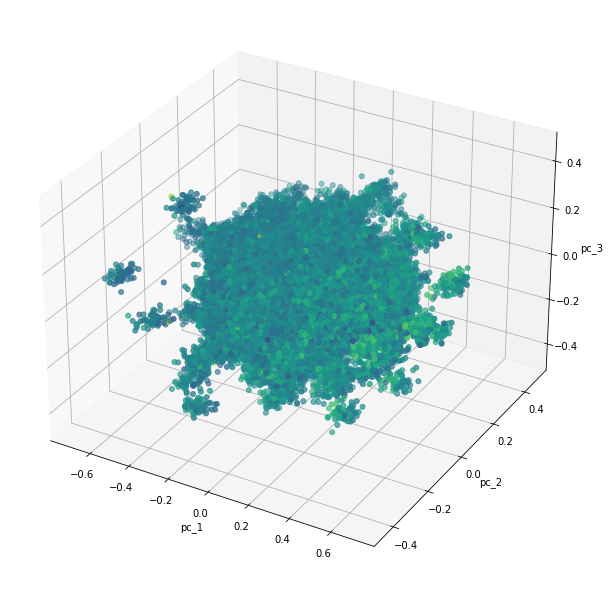

In [30]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def show_pca_df(df):

    
	x = df[df.columns[2:7]].to_numpy()
	y = df[df.columns[8]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)
    
	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

show_pca_df(df)





In [33]:
df_anomaly = df[df[df.columns[1]] > 0]
df_normal = df[df[df.columns[1]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
df = pd.concat([ df_anomaly, df_normal])

show_pca_df(df)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by MinMaxScaler.

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


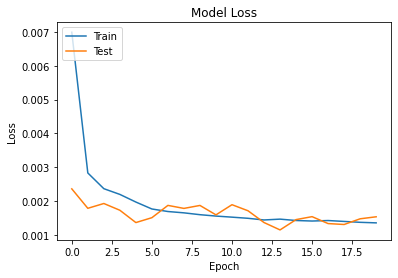

In [34]:

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing





df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:8]].to_numpy()
# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']



# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.2)

n_features = x.shape[1]


# # model
encoder = keras.Sequential(name='encoder')
encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
encoder.add(keras.layers.Dropout(0.1))
encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

decoder = keras.Sequential(name='decoder')
decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
decoder.add(keras.layers.Dropout(0.1))
decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

autoencoder = keras.Sequential([encoder, decoder])

autoencoder.compile(
	loss=keras.losses.MSE,
	optimizer=keras.optimizers.Adam(),
	metrics=[keras.metrics.mean_squared_error])

# train model
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=20, verbose=0, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
0.002709545847028493
0.0015349394


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



MAE
9.170190811157227
4213.0273


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



MLE
0.0011059883050620549
0.00068352465


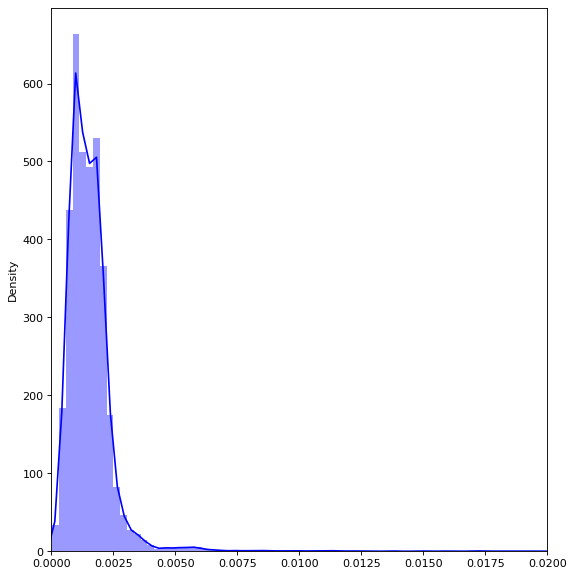

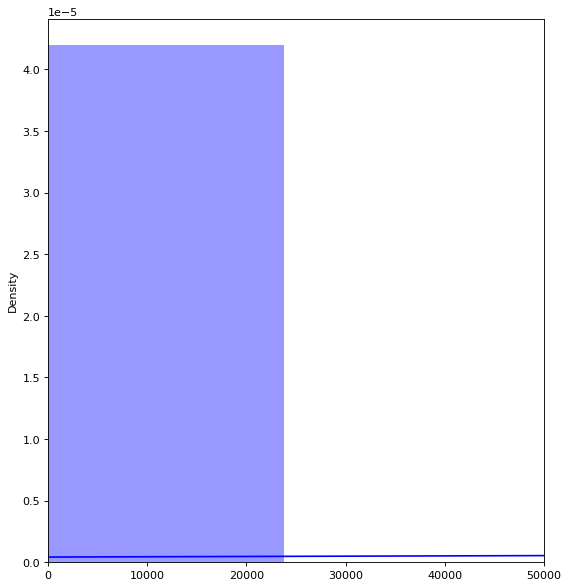

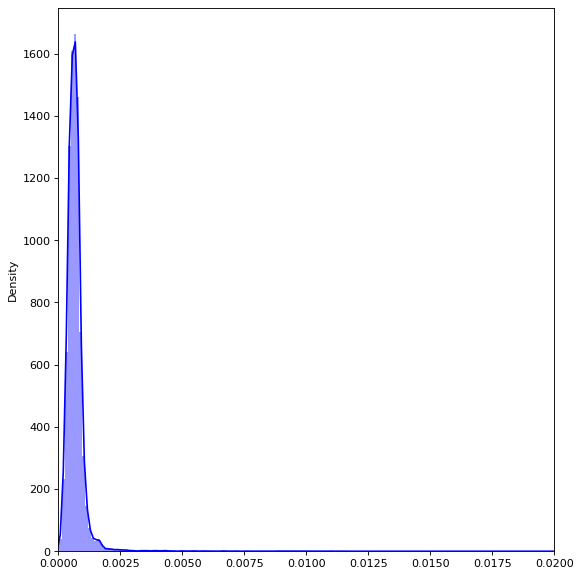

In [55]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))



# Mean Absolute error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mae = keras.losses.mean_absolute_percentage_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mae, 95)


# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mae, bins=2000, kde=True, color='blue')
plt.xlim([0., 50000]);


print('')
print('MAE')
print(cut_off)
print(np.average(train_events_mae.numpy()))


# Mean Log error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mle = keras.losses.mean_squared_logarithmic_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mle, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mle, bins=200, kde=True, color='blue')
plt.xlim([0., .02]);

print('')
print('MLE')
print(cut_off)
print(np.average(train_events_mle.numpy()))



In [19]:
import seaborn as sns
plot_samples = 99
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
print(mse_df)
x=mse_df.n
y=mse_df.mse,
mse_df.to_excel('test.xlsx')
# plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

# line = plt.lines.Line2D(
# 	xdata=np.arange(0, plot_samples),
# 	ydata=np.full(plot_samples, cut_off),
# 	color='#CC2B5E',
# 	linewidth=1.5,
# 	linestyle='dashed')

# plt.plot.add_artist(line)
# plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
# plt.show()

ValueError: cannot reshape array of size 546 into shape (99,7)

In [44]:
df = pd.read_excel('Fault 40.xlsx',engine='openpyxl')
print(df)
plot_samples=1201
# all features
x = df[df.columns[2:8]].to_numpy()
# column with class
y = df[df.columns[1]].to_numpy()




df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)

abnormal_events = df

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse,
	'anomaly': np.ones(plot_samples)})

x=mse_df.n
y=mse_df.mse,
abnormal_events_df.to_excel('test4.xlsx')



      Var1  Class        Ci          Ti         C           T          Qc  \
0        0      0  1.030513  350.778527  0.099384  430.871209  148.814799   
1        1      0  1.029564  351.255911  0.101274  430.910049  149.201249   
2        2      0  1.028076  351.089261  0.102826  430.415965  146.385718   
3        3      0  1.027996  351.399371  0.097840  431.518419  147.980219   
4        4      0  1.029284  350.949416  0.093054  432.535963  156.651259   
...    ...    ...       ...         ...       ...         ...         ...   
1196  1196      1  0.978220  349.732360  0.091048  432.097287  199.713339   
1197  1197      1  0.977618  349.310307  0.084909  433.985044  200.333432   
1198  1198      1  0.976726  349.876704  0.082744  434.426010  200.289803   
1199  1199      1  0.977003  349.574596  0.082439  434.626850  200.417551   
1200  1200      1  0.965837  350.278277  0.080900  434.972682  199.592563   

             Tci          Tc  
0     348.613714  416.838537  
1     348.280

In [ ]:
df = pd.read_excel('Fault 20.xlsx',engine='openpyxl')
print(df)
plot_samples=50
# all features
x = df[df.columns[2:8]].to_numpy()
# column with class
y = df[df.columns[1]].to_numpy()


df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)


normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

plot_samples=78

# abnormal_events = df
# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.MAE(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse,
	'anomaly': np.ones(plot_samples)})

abnormal_events_df=pd.DataFrame(abnormal_events_df)



plot_samples=1123
# normal event
normal_x = scaler.transform(normal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(normal_events)
normal_events_mse =  keras.losses.mean_squared_error(normal_x, predicted_x)
normal_events_df = pd.DataFrame({
	'n': np.arange(0, plot_samples),    
	'mse': normal_events_mse,
	'anomaly': np.zeros(plot_samples)})






mse_df = pd.concat([normal_events_df, abnormal_events_df])









print(abnormal_events_df)
x=mse_df.n
y=mse_df.mse,
mse_df.to_excel('test4.xlsx')
